##### Libraries used

In [ ]:
# General libraries 
import numpy as np
import pandas as pd

# For filtering
from scipy.signal import butter, filtfilt, welch

# For data loading
import os

# For feature extraction
from scipy.stats import skew, kurtosis, zscore
from scipy.fft import fft
from scipy.integrate import simps

# For standardization
from sklearn.preprocessing import StandardScaler

# For modelling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
# data_path =  "Data/"
data_path =  "../Data"

##### Filtering EEG data

In [70]:
# function for bandpass filter for the preprocessing the while loading
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

##### Feature Extraction 

In [71]:
# function to calculate the features (summary statistics, power of the EEG rhythms, and resonance frequency.)
def calculate_features_for_channel(signal, fs, channel_name):
    features = {}

    # Basic summary statistics
    features[f'mean_{channel_name}'] = np.mean(signal)
    features[f'median_{channel_name}'] = np.median(signal)
    features[f'std_{channel_name}'] = np.std(signal)
    features[f'skewness_{channel_name}'] = skew(signal)
    features[f'kurtosis_{channel_name}'] = kurtosis(signal)

    # Power spectral density (PSD)
    f, Pxx = welch(signal, fs=fs, nperseg=1024)
    features[f'delta_power_{channel_name}'] = simps(Pxx[(f >= 0.5) & (f < 4)])
    features[f'theta_power_{channel_name}'] = simps(Pxx[(f >= 4) & (f < 8)])
    features[f'alpha_power_{channel_name}'] = simps(Pxx[(f >= 8) & (f < 13)])
    features[f'beta_power_{channel_name}'] = simps(Pxx[(f >= 13) & (f < 30)])
    features[f'gamma_power_{channel_name}'] = simps(Pxx[(f >= 30) & (f < 40)])

    # Resonance Frequency/Dominant frequency
    fft_result = fft(signal.values)
    freqs = np.fft.fftfreq(len(fft_result), 1 / fs)
    features[f'dominant_frequency_{channel_name}'] = freqs[np.argmax(np.abs(fft_result))]

    return features

In [72]:
# function to extract the feature and make a dataframe using the features

#The specific values of 0.5 Hz and 30 Hz are commonly used in EEG processing for sleep studies.
lowcut = 0.5
highcut = 30
#In EEG signal processing, a common sampling rate is 100 Hz.
fs = 100

def extract_features_from_file(file_path):
    df = pd.read_csv(file_path)

    # Apply bandpass filter to EEG data
    df['EEG Fpz-Cz'] = bandpass_filter(df['EEG Fpz-Cz'], lowcut, highcut, fs)
    df['EEG Pz-Oz'] = bandpass_filter(df['EEG Pz-Oz'], lowcut, highcut, fs)

    # Calculate features
    features_fpz = calculate_features_for_channel(df['EEG Fpz-Cz'], fs, "Fpz_Cz")
    features_pz = calculate_features_for_channel(df['EEG Pz-Oz'], fs, "Pz_Oz")
    features_df = features_fpz.copy()  # Create a copy of dict1 to avoid modifying it directly
    features_df.update(features_pz)

    return features_df

In [73]:
# Load and extract features from each file in the Train and Test folder
train_test_paths = [os.path.join(data_path, folder) for folder in ["Train", "Test"]]
train_features_list = []
test_features_list = []
for train_test_path in train_test_paths:
    for label in os.listdir(train_test_path):
        label_path = os.path.join(train_test_path, label)
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            features = extract_features_from_file(file_path)
            features['Stage'] = label  # Add label information
            if("Train" in train_test_path):
              train_features_list.append(features)
            else:
              test_features_list.append(features)

# Create separate DataFrames for training and test features
train_features_df = pd.DataFrame(train_features_list)
test_features_df = pd.DataFrame(test_features_list)

In [74]:
# Display basic information about the loaded data
print("Training Data:")
print(train_features_df.info())

Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5963 entries, 0 to 5962
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mean_Fpz_Cz                5963 non-null   float64
 1   median_Fpz_Cz              5963 non-null   float64
 2   std_Fpz_Cz                 5963 non-null   float64
 3   skewness_Fpz_Cz            5963 non-null   float64
 4   kurtosis_Fpz_Cz            5963 non-null   float64
 5   delta_power_Fpz_Cz         5963 non-null   float64
 6   theta_power_Fpz_Cz         5963 non-null   float64
 7   alpha_power_Fpz_Cz         5963 non-null   float64
 8   beta_power_Fpz_Cz          5963 non-null   float64
 9   gamma_power_Fpz_Cz         5963 non-null   float64
 10  dominant_frequency_Fpz_Cz  5963 non-null   float64
 11  mean_Pz_Oz                 5963 non-null   float64
 12  median_Pz_Oz               5963 non-null   float64
 13  std_Pz_Oz                  5963 n

In [75]:
print("\nTest Data:")
print(test_features_df.info())


Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mean_Fpz_Cz                1906 non-null   float64
 1   median_Fpz_Cz              1906 non-null   float64
 2   std_Fpz_Cz                 1906 non-null   float64
 3   skewness_Fpz_Cz            1906 non-null   float64
 4   kurtosis_Fpz_Cz            1906 non-null   float64
 5   delta_power_Fpz_Cz         1906 non-null   float64
 6   theta_power_Fpz_Cz         1906 non-null   float64
 7   alpha_power_Fpz_Cz         1906 non-null   float64
 8   beta_power_Fpz_Cz          1906 non-null   float64
 9   gamma_power_Fpz_Cz         1906 non-null   float64
 10  dominant_frequency_Fpz_Cz  1906 non-null   float64
 11  mean_Pz_Oz                 1906 non-null   float64
 12  median_Pz_Oz               1906 non-null   float64
 13  std_Pz_Oz                  1906 non-

##### Checking for Missing Values

In [76]:
# Check for missing values in the loaded data
print("Missing values in Training Data:")
print(train_features_df.isnull().sum())

Missing values in Training Data:
mean_Fpz_Cz                  0
median_Fpz_Cz                0
std_Fpz_Cz                   0
skewness_Fpz_Cz              0
kurtosis_Fpz_Cz              0
delta_power_Fpz_Cz           0
theta_power_Fpz_Cz           0
alpha_power_Fpz_Cz           0
beta_power_Fpz_Cz            0
gamma_power_Fpz_Cz           0
dominant_frequency_Fpz_Cz    0
mean_Pz_Oz                   0
median_Pz_Oz                 0
std_Pz_Oz                    0
skewness_Pz_Oz               0
kurtosis_Pz_Oz               0
delta_power_Pz_Oz            0
theta_power_Pz_Oz            0
alpha_power_Pz_Oz            0
beta_power_Pz_Oz             0
gamma_power_Pz_Oz            0
dominant_frequency_Pz_Oz     0
Stage                        0
dtype: int64


In [77]:
print(train_features_df.isna().sum())

mean_Fpz_Cz                  0
median_Fpz_Cz                0
std_Fpz_Cz                   0
skewness_Fpz_Cz              0
kurtosis_Fpz_Cz              0
delta_power_Fpz_Cz           0
theta_power_Fpz_Cz           0
alpha_power_Fpz_Cz           0
beta_power_Fpz_Cz            0
gamma_power_Fpz_Cz           0
dominant_frequency_Fpz_Cz    0
mean_Pz_Oz                   0
median_Pz_Oz                 0
std_Pz_Oz                    0
skewness_Pz_Oz               0
kurtosis_Pz_Oz               0
delta_power_Pz_Oz            0
theta_power_Pz_Oz            0
alpha_power_Pz_Oz            0
beta_power_Pz_Oz             0
gamma_power_Pz_Oz            0
dominant_frequency_Pz_Oz     0
Stage                        0
dtype: int64


In [78]:
print("\nMissing values in Test Data:")

print(test_features_df.isnull().sum())


Missing values in Test Data:
mean_Fpz_Cz                  0
median_Fpz_Cz                0
std_Fpz_Cz                   0
skewness_Fpz_Cz              0
kurtosis_Fpz_Cz              0
delta_power_Fpz_Cz           0
theta_power_Fpz_Cz           0
alpha_power_Fpz_Cz           0
beta_power_Fpz_Cz            0
gamma_power_Fpz_Cz           0
dominant_frequency_Fpz_Cz    0
mean_Pz_Oz                   0
median_Pz_Oz                 0
std_Pz_Oz                    0
skewness_Pz_Oz               0
kurtosis_Pz_Oz               0
delta_power_Pz_Oz            0
theta_power_Pz_Oz            0
alpha_power_Pz_Oz            0
beta_power_Pz_Oz             0
gamma_power_Pz_Oz            0
dominant_frequency_Pz_Oz     0
Stage                        0
dtype: int64


In [79]:
print(test_features_df.isna().sum())

mean_Fpz_Cz                  0
median_Fpz_Cz                0
std_Fpz_Cz                   0
skewness_Fpz_Cz              0
kurtosis_Fpz_Cz              0
delta_power_Fpz_Cz           0
theta_power_Fpz_Cz           0
alpha_power_Fpz_Cz           0
beta_power_Fpz_Cz            0
gamma_power_Fpz_Cz           0
dominant_frequency_Fpz_Cz    0
mean_Pz_Oz                   0
median_Pz_Oz                 0
std_Pz_Oz                    0
skewness_Pz_Oz               0
kurtosis_Pz_Oz               0
delta_power_Pz_Oz            0
theta_power_Pz_Oz            0
alpha_power_Pz_Oz            0
beta_power_Pz_Oz             0
gamma_power_Pz_Oz            0
dominant_frequency_Pz_Oz     0
Stage                        0
dtype: int64


So we can conclude there are no missing values.  

##### Splitting the dataset into features(X) and labels(y)

In [80]:
train_X = train_features_df.iloc[:, :-1]
train_y = train_features_df.iloc[:, -1]
test_X = test_features_df.iloc[:, :-1]
test_y = test_features_df.iloc[:, -1]

##### Standardization of the dataset

In [81]:
# Standardize train_X
scaler_X = StandardScaler()
train_X_standardized = scaler_X.fit_transform(train_X)

# Apply the same transformation to test data
test_X_standardized = scaler_X.transform(test_X)

# Convert back to dataframes
train_X_standardized_df = pd.DataFrame(train_X_standardized, columns=train_X.columns)
test_X_standardized_df = pd.DataFrame(test_X_standardized, columns=test_X.columns)


##### KNN Classification and Evaluation of the Model

In [82]:
# Convert Pandas DataFrames to NumPy arrays
train_X_standardized = train_X_standardized_df.values
train_y = train_y.values
test_X_standardized = test_X_standardized_df.values

# Instantiate kNN Classifier
k = 5 
knn = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn.fit(train_X_standardized, train_y)

# Predictions
y_pred = knn.predict(test_X_standardized)

# Evaluation
knn_accuracy = metrics.accuracy_score(test_y, y_pred)
print("Accuracy:", knn_accuracy)

print("KNN Classification Report:")
print(classification_report(test_y, y_pred))

Accuracy: 0.6925498426023085
KNN Classification Report:
              precision    recall  f1-score   support

       Awake       0.93      0.91      0.92       450
          N1       0.53      0.39      0.45       295
          N2       0.66      0.76      0.71       450
          N3       0.75      0.67      0.71       310
          N4       0.16      0.30      0.21        33
         REM       0.60      0.64      0.62       368

    accuracy                           0.69      1906
   macro avg       0.61      0.61      0.60      1906
weighted avg       0.70      0.69      0.69      1906



##### SVM Classification and Evaluation of the Model

In [83]:
# Applying SVM classifier 

# Initialize the classifiers
svm_classifier = SVC()

# Train the classifiers
svm_classifier.fit(train_X_standardized_df, train_y)

SVC()

In [84]:
# Make predictions on the test set
svm_predictions = svm_classifier.predict(test_X_standardized_df)

# Evaluate performance
svm_accuracy = accuracy_score(test_y, svm_predictions)
svm_report = classification_report(test_y, svm_predictions)

print("SVM Classifier Accuracy:", svm_accuracy)
print("\nSVM Classifier Report:\n", svm_report)

SVM Classifier Accuracy: 0.7644281217208815

SVM Classifier Report:
               precision    recall  f1-score   support

       Awake       0.93      0.99      0.96       450
          N1       0.71      0.28      0.40       295
          N2       0.78      0.83      0.81       450
          N3       0.84      0.80      0.82       310
          N4       0.44      0.21      0.29        33
         REM       0.58      0.81      0.67       368

    accuracy                           0.76      1906
   macro avg       0.71      0.65      0.66      1906
weighted avg       0.77      0.76      0.75      1906



##### Random Forest Classification and Evaluation of the Model

In [85]:
# Applying Random Forest Classifier 
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_X_standardized_df, train_y)

RandomForestClassifier()

In [86]:
# Make predictions on the test set
rf_predictions = rf_classifier.predict(test_X_standardized_df)

# Evaluate performance
rf_accuracy = accuracy_score(test_y, rf_predictions)
rf_report = classification_report(test_y, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("\nRandom Forest Classifier Report:\n", rf_report)


Random Forest Classifier Accuracy: 0.7948583420776495

Random Forest Classifier Report:
               precision    recall  f1-score   support

       Awake       0.96      1.00      0.98       450
          N1       0.67      0.52      0.59       295
          N2       0.79      0.87      0.82       450
          N3       0.86      0.73      0.79       310
          N4       0.48      0.42      0.45        33
         REM       0.68      0.76      0.72       368

    accuracy                           0.79      1906
   macro avg       0.74      0.72      0.72      1906
weighted avg       0.79      0.79      0.79      1906



##### Comparison of classifiers

In [87]:
# Calculate confusion matrix
svm_conf_matrix = confusion_matrix(test_y, svm_predictions)
rf_conf_matrix = confusion_matrix(test_y, rf_predictions)
knn_conf_matrix = confusion_matrix(test_y, y_pred) 

# Calculate precision, recall, and F1-score
svm_precision = precision_score(test_y, svm_predictions, average='weighted')
rf_precision = precision_score(test_y, rf_predictions, average='weighted')
knn_precision = precision_score(test_y, y_pred, average='weighted')

svm_recall = recall_score(test_y, svm_predictions, average='weighted')
rf_recall = recall_score(test_y, rf_predictions, average='weighted')
knn_recall = recall_score(test_y, y_pred, average='weighted')

svm_f1 = f1_score(test_y, svm_predictions, average='weighted')
rf_f1 = f1_score(test_y, rf_predictions, average='weighted')
knn_f1 = f1_score(test_y, y_pred, average='weighted') 

print("SVM Classifier:")
print("Confusion Matrix:\n", svm_conf_matrix)
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)

print("\nRandom Forest Classifier:")
print("Confusion Matrix:\n", rf_conf_matrix)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

SVM Classifier:
Confusion Matrix:
 [[446   0   4   0   0   0]
 [ 14  82  25   1   0 173]
 [  6   4 375  20   0  45]
 [  1   0  51 249   9   0]
 [  0   0   0  26   7   0]
 [ 14  30  26   0   0 298]]
Accuracy: 0.7644281217208815
Precision: 0.768291426891874
Recall: 0.7644281217208815
F1 Score: 0.7469387552924907

Random Forest Classifier:
Confusion Matrix:
 [[450   0   0   0   0   0]
 [  6 154  22   0   0 113]
 [  6  12 391  19   0  22]
 [  1   0  69 225  15   0]
 [  0   0   0  19  14   0]
 [  7  64  16   0   0 281]]
Accuracy: 0.7948583420776495
Precision: 0.7929712166879523
Recall: 0.7948583420776495
F1 Score: 0.7904728390202423


In [90]:
print("\n KNN Classifier:")
print("Confusion Matrix:\n", knn_conf_matrix)
print("Accuracy:", knn_accuracy)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 Score:", knn_f1)


 KNN Classifier:
Confusion Matrix:
 [[410   2  17   8  13   0]
 [  6 116  51   0   1 121]
 [  5  27 341  40   1  36]
 [  2   0  63 209  36   0]
 [  0   0   2  21  10   0]
 [ 17  73  43   1   0 234]]
Accuracy: 0.6925498426023085
Precision: 0.6983035267188578
Recall: 0.6925498426023085
F1 Score: 0.6921939846095168


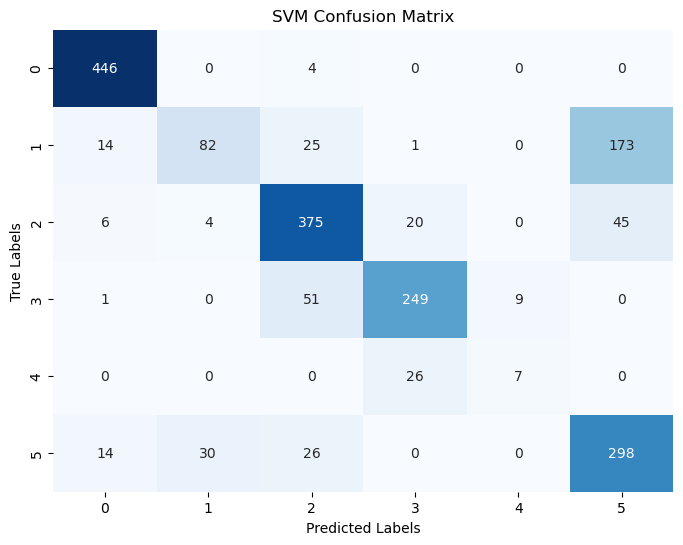

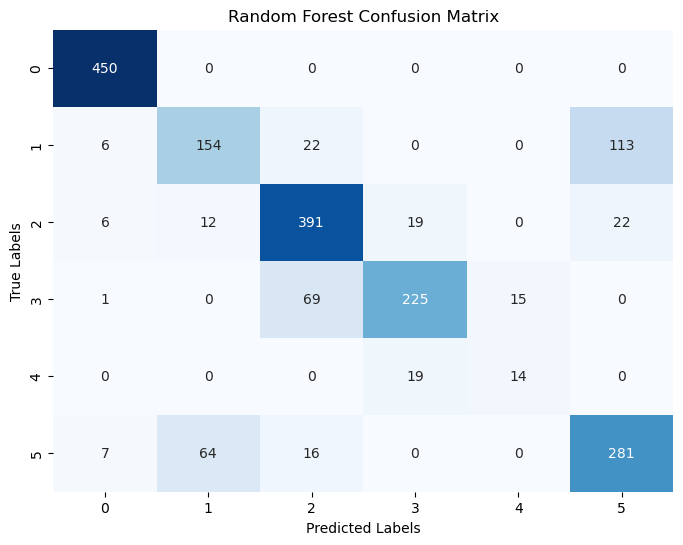

In [88]:
# Define function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(svm_conf_matrix, title="SVM Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, title="Random Forest Confusion Matrix")


### Discussion
1. The accuracy of all 3 classifiers is similar, but the Random Forest and SVM classifiers perform significantly better than KNN in most cases. Random Forest performs the best.
2. The Random Forest classifier outperforms the SVM classifier in terms of accuracy, recall, and F1-score values, suggesting that the SVM classifier has greater difficulty with certain classes.
3. On this dataset, the Random Forest classifier performs better than the SVM classifier on every metric.

To enhance these classifiers' performance, more research and adjustment could be necessary.



In [89]:
# Applying K-fold cross validation to improve the performance

# Define k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform k-fold cross-validation for SVM
svm_cv_scores = cross_val_score(svm_classifier, train_X_standardized_df, train_y, cv=kfold, scoring='accuracy')

# Perform k-fold cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_classifier, train_X_standardized_df, train_y, cv=kfold, scoring='accuracy')

# Print the cross-validation scores
print("SVM Classifier Cross-Validation Scores:", svm_cv_scores)
print("Mean Accuracy:", svm_cv_scores.mean())

print("\nRandom Forest Classifier Cross-Validation Scores:", rf_cv_scores)
print("Mean Accuracy:", rf_cv_scores.mean())


SVM Classifier Cross-Validation Scores: [0.77284158 0.78290025 0.80217938 0.78942953 0.79362416]
Mean Accuracy: 0.7881949796632481

Random Forest Classifier Cross-Validation Scores: [0.84241408 0.84409053 0.84325231 0.83389262 0.85402685]
Mean Accuracy: 0.8435352756853456


### Conclusion
The Random Forest classifier outperformed the SVM classifier in terms of accuracy prior to k-fold cross-validation. But after k-fold cross-validation, the Random Forest classifier significantly outperformed the SVM classifier in terms of mean accuracy.
For every k-fold cross-validation fold, the Random Forest classifier outperformed the SVM classifier, yielding an improved average accuracy.
The Random Forest classifier outperforms the SVM classifier for this dataset in terms of robustness and generalization to previously unknown data, according to the results of the k-fold cross-validation.
After applying k-fold cross-validation, the mean accuracy of both classifiers increased, indicating that the initial assessment could have been somewhat skewed as a result of the data's random division into train and test sets. K-fold cross-validation averages over several data splits to provide a more reliable estimate of classifier performance.



